<a href="https://colab.research.google.com/github/ErikHartman/BMEN35/blob/2023/BMEN35_notebook_collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise about xAI and omics

This exercise is about methods in the field of explainable AI (xAI) and they're application to omics data. Specifically, we'll use SHapley Additive exPlanations (SHAP) to introspect trained models to understand their reasoning during classification tasks.

The exercise has two parts:

1. In the first part, you'll get to train a neural network on the MNIST dataset (digits 0-9). Thereafter you'll explain a set of predictions using SHAP. 
2. In the second part, we'll apply a similar methodology but to a clinical proteomic dataset. Here, SHAP is used to explain what proteins a classifier deems important when classifying two different subtypes of septic acute kidney injury.




In [2]:
!pip install shap
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## Part 1

Here you will train a convolutional neural network to classify the digits 0-9 (MINST dataset). Thereafter you will interpret the network using SHAP. Familiarize yourself with the code and make sure you understand every step.

In [3]:
import numpy as np
import keras
from keras import layers
from keras.utils import to_categorical


num_classes = 10  # 0-9
input_shape = (28, 28, 1)  # pixels

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

batch_size = 128
epochs = 2

model = keras.Sequential(
    [
        layers.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])
print("---- Model is trained, time for interpretation ----")

/Users/albertahnlide/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                 

Now it's time to interpret using SHAP. 

The background is a representative set of datapoints which should capture the "average output" of the network. This is simply to establish a baseline that outputs can be compared against later when explaining the network.

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


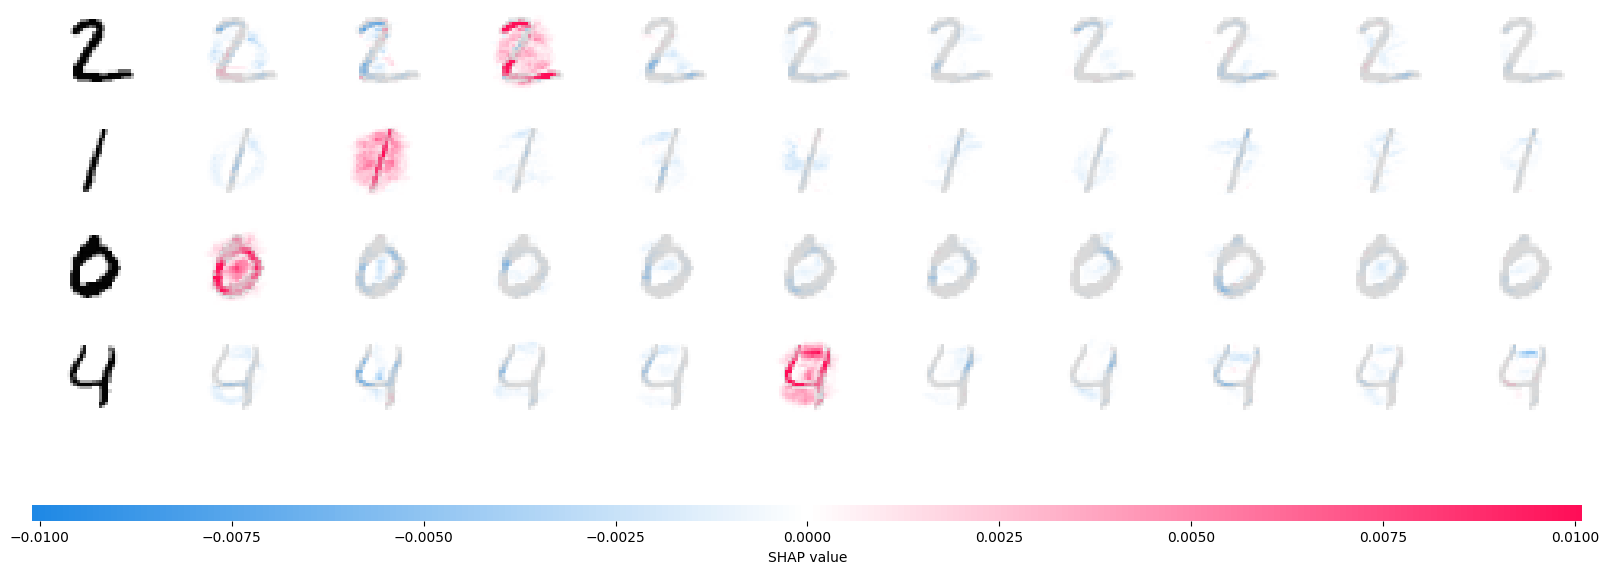

In [4]:
import shap

# select a set of background examples to take an expectation over
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

# Create the explainer object
e = shap.DeepExplainer(model, background)

# Compute the SHAP values
shap_values = e.shap_values(x_test[1:5])
# Show them in an image
shap.image_plot(shap_values, -x_test[1:5])

### Question: what features seem important for the different digits? You can change the x_test slice to see other digits.

The dufferent features for each digit: 

2: It seems like the horizontal line in for the base of the 2 is important as well as the curved top. The white around the digit also seems to be helping.

1: A vertical stroke of black as well as white around the digit.

0: It seems like the sides in the horizontal plane is important as well as the white in the middle of the digit. 

4: The two lines in the upper part of the digit seems to be an important feature. It also seems like the abscens of a horizontal line between these two vertical lines is very important. I think this is because it needs to differentiate between a 9 and a 4.





## Part 2

Now it's time to apply the same principles but to some biological data.

The data used here is the septic AKI data (see lecture).

In [5]:
import pandas as pd

# load the data from GitHub
data_matrix = pd.read_csv(
    "https://raw.githubusercontent.com/ErikHartman/BMEN35/2023/data/quant_matrix.csv"
)
design_matrix = pd.read_csv(
    "https://raw.githubusercontent.com/ErikHartman/BMEN35/2023/data/inner_design_matrix.tsv",
    sep="\t",
)
human_proteome = pd.read_csv(
    "https://raw.githubusercontent.com/ErikHartman/BMEN35/2023/data/human_proteome.gz",
    sep=",",
)

In [6]:
def get_proteins_triv_name(proteins, proteome):
    # function to map Uniprot IDs to more common names.
    proteome["accession"] = proteome["accession"].apply(lambda x: x.split("_")[0])
    names = []
    for protein in proteins:
        if protein in proteome["accession"].values:
            m = proteome.loc[proteome["accession"] == protein]["trivname"].values
            assert len(m) == 1
            m = m[0].split("_")[0]
        else:
            m = protein
        names.append(m)
    return names

In [7]:
group_one_samples = design_matrix[design_matrix["group"] == 1]["sample"].values
group_two_samples = design_matrix[design_matrix["group"] == 2]["sample"].values
data_matrix.head()

,Protein,TM_P1911_190,TM_P1911_191,TM_P1911_192,TM_P1911_193,TM_P1911_194,TM_P1911_196,TM_P1911_197,TM_M2012_010,TM_M2012_011,...,TM_M2012_190,TM_M2012_191,TM_M2012_192,TM_M2012_196,TM_M2012_197,TM_M2012_198,TM_M2012_199,TM_M2012_200,TM_M2012_202,TM_M2012_203
0,P08603,22.381866,22.773908,22.732549,22.960530,22.906198,23.167862,23.122564,23.110142,23.179716,...,23.416677,23.498007,23.459972,23.403313,23.454894,23.602666,23.682634,23.665858,24.015710,23.655648
1,P02671,25.349974,25.431340,25.459891,25.275259,25.592789,24.829806,24.208987,23.984077,26.075865,...,24.984516,25.023149,24.971465,23.369445,24.604836,24.623221,24.787905,25.095571,25.103341,24.914344
2,P01042,22.061788,21.872170,21.966596,22.256140,22.505168,22.993978,23.277504,22.963205,22.767097,...,22.953879,23.089170,23.018547,23.280626,23.503529,23.471356,23.471414,23.193750,24.101306,23.486766
3,P00450,22.647246,23.193086,23.332780,23.206429,22.959381,23.008403,22.770807,22.971128,23.373016,...,23.788756,23.932623,23.904721,23.273831,23.462794,23.783564,23.968122,23.956618,23.989086,23.834912
4,P05156,21.301448,21.435684,21.304184,21.459141,21.532018,22.006447,21.968122,21.688934,21.372610,...,21.850530,21.883567,21.936084,21.778412,22.051000,22.187546,21.965964,21.820840,22.373783,22.076671


Preprocess the data.

In [8]:
from sklearn import preprocessing

protein_labels = get_proteins_triv_name(
    data_matrix["Protein"].values, human_proteome
)  # the UniProt IDs are translated to more common names.

df1 = data_matrix[group_one_samples].T
df2 = data_matrix[group_two_samples].T
df1.columns = protein_labels
df2.columns = protein_labels

y = np.array(
    [0 for _ in group_one_samples] + [1 for _ in group_two_samples]
)  
df_X = pd.concat([df1, df2]).fillna(0)
X = df_X.to_numpy()
scaler = preprocessing.StandardScaler().fit(X)  # makes mean = 0 and variance = 1
X_scaled = scaler.transform(X)  # this is our scaled X

df_X_scaled = pd.DataFrame(X_scaled)  # puts everything into a pandas DataFrame
df_X_scaled.columns = df_X.columns
df_X_scaled

,CFAH,FIBA,KNG1,CERU,CFAI,CO1A1,CO7,IGLL5,TRFE,HPT,...,P01616,CTRB1,MFAP4,4F2,P18136,CSF1R,PSME1,TIMP2,FSTL3,RB27B
0,0.474120,-1.748935,0.568842,-0.554017,0.420675,-1.626960,0.474942,0.549018,1.353755,-0.247690,...,0.607345,-0.253816,-0.456284,-0.316671,-0.589943,1.354016,-0.191647,-0.535355,-0.124093,-0.071429
1,0.699739,2.301029,0.059307,0.377119,-0.145055,0.589385,-0.549855,-1.470286,-0.579473,0.178393,...,0.000225,-0.253816,-0.456284,-0.316671,-0.589943,-0.708802,-0.191647,-0.535355,-0.124093,-0.071429
2,0.616734,0.747695,0.528698,1.046836,0.078350,0.587803,-0.058332,-1.195053,0.025206,0.419302,...,-0.074833,-0.253816,2.139618,-0.316671,-0.589943,-0.708802,-0.191647,1.802819,-0.124093,-0.071429
3,1.606663,0.302478,1.550630,1.738238,0.690851,0.415007,0.303058,-1.215262,0.025584,0.617930,...,-0.029424,-0.253816,2.218473,-0.316671,-0.589943,1.175290,-0.191647,-0.535355,-0.124093,-0.071429
4,1.416180,1.772326,1.499721,1.163521,0.373920,0.255424,0.178799,-1.137548,-0.370086,0.508600,...,-0.042314,-0.253816,2.143739,-0.316671,-0.589943,-0.708802,-0.191647,-0.535355,-0.124093,-0.071429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,2.071304,-0.511473,1.889137,1.328322,1.312417,0.696954,-0.059947,-0.007676,2.551985,-2.530578,...,-0.431806,-0.253816,-0.456284,-0.316671,-0.589943,-0.708802,-0.191647,-0.535355,-0.124093,-0.071429
193,2.330629,-0.192622,1.889287,1.755925,0.916130,0.619886,0.359412,-0.093331,2.396032,-3.784795,...,-0.151382,-0.253816,-0.456284,-0.316671,-0.589943,-0.708802,-0.191647,-0.535355,-0.124093,-0.071429
194,2.276228,0.403057,1.167853,1.729271,0.656582,0.553426,0.930050,0.198921,2.322438,-4.093601,...,0.568234,-0.253816,-0.456284,-0.316671,-0.589943,-0.708802,5.318793,-0.535355,-0.124093,-0.071429
195,3.410748,0.418100,3.525893,1.804496,1.645494,0.177873,2.182560,0.293043,1.227210,-2.100192,...,0.405155,-0.253816,-0.456284,-0.316671,-0.589943,-0.708802,-0.191647,-0.535355,-0.124093,-0.071429


In [9]:
from xgboost.sklearn import XGBClassifier

""" Train and test how accuarge the XGBoost model is on the data here.
Import the necessary packages. Scikit-learn is available by default in Google Collab
so there is no need to !pip install if you're using that package. """
from sklearn.model_selection import cross_val_score


# Train the model
clf = XGBClassifier()
clf.fit(df_X_scaled, y)


# Test the model, I am using cross validation here because it is a small dataset.
scores = cross_val_score(clf, df_X_scaled, y, cv=5)
print("The scores for the different classes: " + str(scores))
print("The average score for all classes: "+ str(np.mean(scores)))

The scores for the different classes: [0.875      0.95       0.79487179 0.82051282 0.82051282]
The average score for all classes: 0.8521794871794871


[09:52:59] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


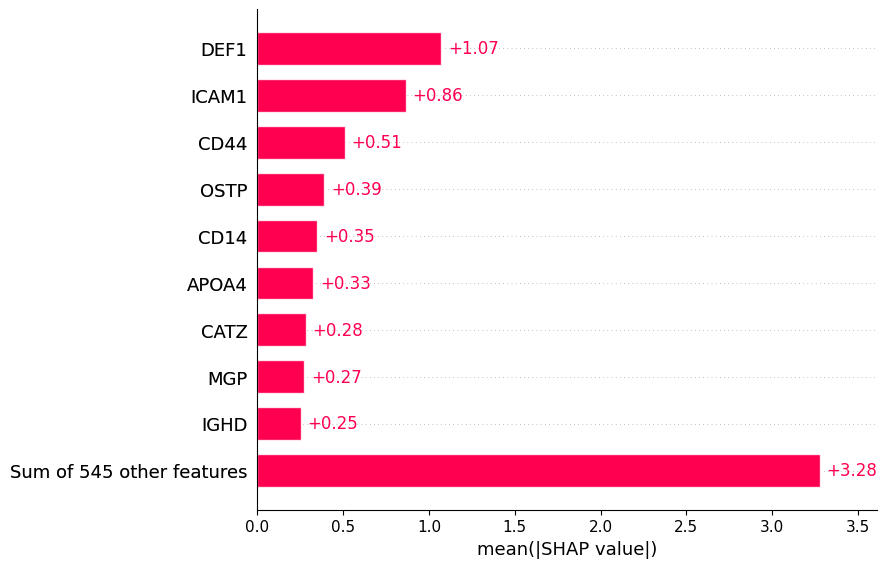

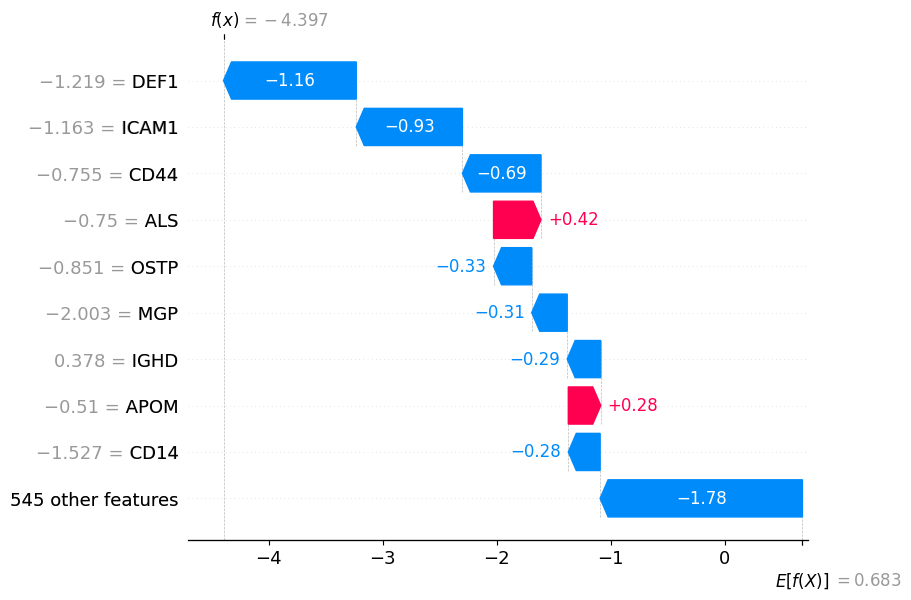

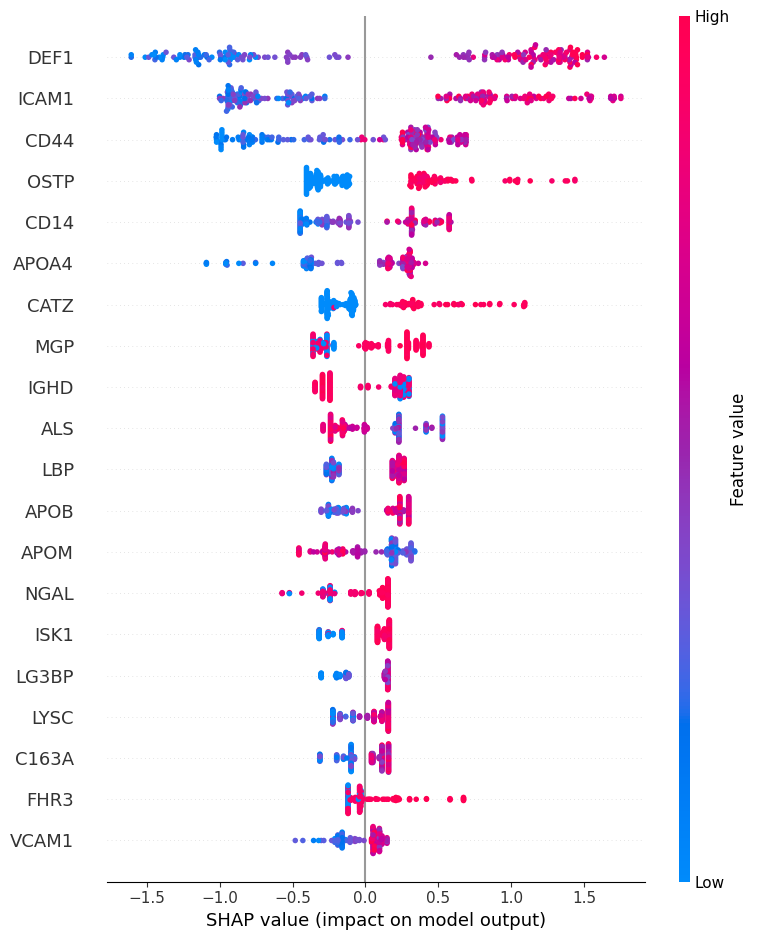

In [10]:
""" Create some SHAP plots here! Feel free to stylize them and do whatever you'd like. """


clf.fit(X_scaled, y)
e = shap.Explainer(clf)
shap_values = e(df_X_scaled)

# Making the plots
shap.plots.bar(shap_values)
shap.plots.waterfall(shap_values[0])


names = df_X_scaled.columns.values.tolist()


shap.summary_plot(shap_values, X_scaled, names)

### The last task is to look at your top scoring proteins. Can you find any reference or other information linking these to septic AKI? Write in markdown below.


DEF1 is an antibacterial protein which protects the podocytes in the kidneys. Therefore, it is expectable to have an impact on the model's decision. 

https://www.mdpi.com/1422-0067/17/10/1637


While the kidneys are damaged in septic AKI, the immune system is activated and needs to travel to the kidneys to fight the infection. The protein ICAM1 help to recruit immune cells, while it belongs to the immunoglobulin superfamily which are involved in cell-cell adhesion and signaling. It is therefore quite expectable that the levels of ICAM1 should be higher during septic AKI. 

https://pubmed.ncbi.nlm.nih.gov/24576991/


CD44 is also involved in the recruitment of immune cells when fighting infection. When having a deficiency of CD44, the risk of having septic AKI is elevated which can guide the model to the right result. 

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3871539/